In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_images_path = '../data/fashion/train-images-idx3-ubyte.gz'
train_labels_path = '../data/fashion/train-labels-idx1-ubyte.gz'
test_images_path = '../data/fashion/t10k-images-idx3-ubyte.gz'
test_labels_path = '../data/fashion/t10k-labels-idx1-ubyte.gz'

In [3]:
IMG_H, IMG_W = 28, 28

### Data Loading and Visualization

In [15]:
def load_image_data(filepath):
  """
    Load the idx image data from given path
    
    Parameter(s):
      filepath : path to the image dataset file
  """
  with gzip.open(filepath, 'rb') as img_dataset:
    images = np.frombuffer(img_dataset.read(), dtype=np.uint8, offset=16).reshape(-1, IMG_W, IMG_H)
  return images

In [5]:
def load_label_data(filepath):
  """
    Load the idx label data from given path
    
    Parameter(s):
      filepath : path to the label dataset file
  """
  with gzip.open(filepath, 'rb') as lb_dataset:
    labels = np.frombuffer(lb_dataset.read(), dtype=np.uint8, offset=8)
  return labels

In [6]:
class_label = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
def display_image(image_matrix):
  """
    Display the given image 
    
    Parameter(s):
      image_matrix : 28x28 pixel values matrix
  """
  plt.figure(figsize=(1,1))
  image = np.asarray(image_matrix)
  plt.imshow(image, cmap=plt.cm.binary, interpolation='nearest')
  plt.axis('off')
  plt.show()

In [8]:
# Load images
train_images = load_image_data(train_images_path)
test_images = load_image_data(test_images_path)

In [9]:
# Load labels
train_labels = load_label_data(train_labels_path)
test_labels = load_label_data(test_labels_path)

In [10]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

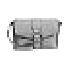

Bag


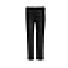

Trouser


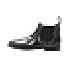

Ankle boot


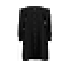

Dress


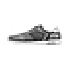

Sneaker


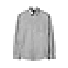

Shirt


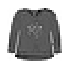

Pullover


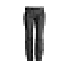

Trouser


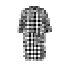

Dress


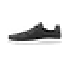

Sneaker


In [11]:
# Display some random items
for img_id in np.random.choice(len(train_images), 10, replace=False):
  display_image(train_images[img_id])
  print(class_label[train_labels[img_id]])
  print('='*50)

### EDA

In [12]:
np.unique(train_labels, return_counts=True)
# Labels are balanced

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [13]:
train_images.max(), train_images.min()
# scaling will be required

(255, 0)

### Data pre-processing

In [29]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout,MaxPooling2D

In [30]:
def preprocess_data(images_arr, labels_arr):
  """
    Take the images and labels data and return the scaled and reshaped form
    
    Parameter(s):
      images_arr : list of images data of shape (samples,img_h,img_w)
      labels_arr : list of labels data of shape (samples,)
  """
  images_arr = images_arr.reshape(-1, IMG_W, IMG_H, 1)
  images_arr = images_arr / 255.0
  labels_arr = to_categorical(labels_arr, num_classes=len(class_label))
  return images_arr, labels_arr

In [23]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                                                      train_labels, 
                                                                      test_size=0.25, 
                                                                      random_state=123)

In [26]:
train_images, train_labels = preprocess_data(train_images, train_labels)
val_images, val_labels = preprocess_data(val_images, val_labels)
test_images, test_labels = preprocess_data(test_images, test_labels)

### Model Building

In [33]:
def create_cnn_model():
  """
    Defines and returns the CNN model
  """
  cnn_model = Sequential()
  cnn_model = Sequential()
  cnn_model.add(Conv2D(32, (3, 3), activation='relu', 
                       kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  cnn_model.add(MaxPooling2D((2, 2)))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  cnn_model.add(Dense(len(class_label), activation='softmax'))
  
  cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  return cnn_model

In [34]:
cnn_model = create_cnn_model()

In [38]:
cnn_model.fit(train_images, train_labels, batch_size=128, epochs=10, verbose=2,
                  validation_data=(val_images, val_labels))

Epoch 1/10
352/352 - 18s - loss: 0.2681 - accuracy: 0.9039 - val_loss: 0.2858 - val_accuracy: 0.9000
Epoch 2/10
352/352 - 21s - loss: 0.2331 - accuracy: 0.9159 - val_loss: 0.2631 - val_accuracy: 0.9069
Epoch 3/10
352/352 - 21s - loss: 0.2022 - accuracy: 0.9256 - val_loss: 0.2774 - val_accuracy: 0.9009
Epoch 4/10
352/352 - 18s - loss: 0.1827 - accuracy: 0.9341 - val_loss: 0.2614 - val_accuracy: 0.9085
Epoch 5/10
352/352 - 23s - loss: 0.1600 - accuracy: 0.9413 - val_loss: 0.2565 - val_accuracy: 0.9109
Epoch 6/10
352/352 - 23s - loss: 0.1445 - accuracy: 0.9481 - val_loss: 0.2572 - val_accuracy: 0.9117
Epoch 7/10
352/352 - 22s - loss: 0.1282 - accuracy: 0.9529 - val_loss: 0.2637 - val_accuracy: 0.9121
Epoch 8/10
352/352 - 14s - loss: 0.1138 - accuracy: 0.9593 - val_loss: 0.2675 - val_accuracy: 0.9099
Epoch 9/10
352/352 - 22s - loss: 0.1005 - accuracy: 0.9636 - val_loss: 0.2671 - val_accuracy: 0.9151
Epoch 10/10
352/352 - 27s - loss: 0.0921 - accuracy: 0.9667 - val_loss: 0.2818 - val_accura

In [41]:
score = cnn_model.evaluate(test_images, test_labels, verbose=0)

In [42]:
score

[0.29096317291259766, 0.909600019454956]